# Recurrent Neural Networks

We'll introduce the concept of recurrent neural networks, which explicitly model the time-dependency of their inputs to facilitate the analysis of sequential data. We'll demonstrate this functionality using a weather forecasting dataset in a classic time-series analysis approach.


## Load Weather Dataset

We download the uncompressed dataset of the Jena Climate Dataset from https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip.

More information on this dataset can be found at https://www.bgc-jena.mpg.de/wetter/.

In [64]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "weather_dataset")
if not os.path.exists(dataset_path):
    url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
    download_url(url, ".")
    _extract_zip("jena_climate_2009_2016.csv.zip", dataset_path, None)
    os.remove("jena_climate_2009_2016.csv.zip")

This dataset contains 14 weather measurements in a `.csv` file. Their meaning is shown in the header.

In [65]:
import csv
from numpy import asarray
    
filename = os.path.join(dataset_path, 'jena_climate_2009_2016.csv')
with open(filename) as f:
    reader = csv.reader(f)
    header = next(reader)
    data = []
    for row in reader:
        data.append(row[1:])  # The first value ('Date Time') is excluded.
    data = asarray(data).astype(float)

print(header)

['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']


## Visualize Data

We now visualize the 14 measured features of the dataset. 

In [70]:
import matplotlib.pyplot as plt
import numpy as np

def plot_data(data, start=0, samples_per_cycle=144, cycles=14):
    """Plot data highlighting periodic cycles."""

    fig, axes = plt.subplots(7, 2, figsize=(16, 12), sharex=True)

    for i, ax in enumerate(axes.flatten()):
        ax.plot(np.arange(start, start + samples_per_cycle * cycles),
                data[start:start + samples_per_cycle * cycles, i], 
                label=header[i + 1])
        ax.legend()
        ax.set_xlim(start, start + samples_per_cycle * cycles)
        
        for cycle in range(1, cycles):
            ax.axvline(x=start + cycle * samples_per_cycle, 
                    color='gray', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.show()

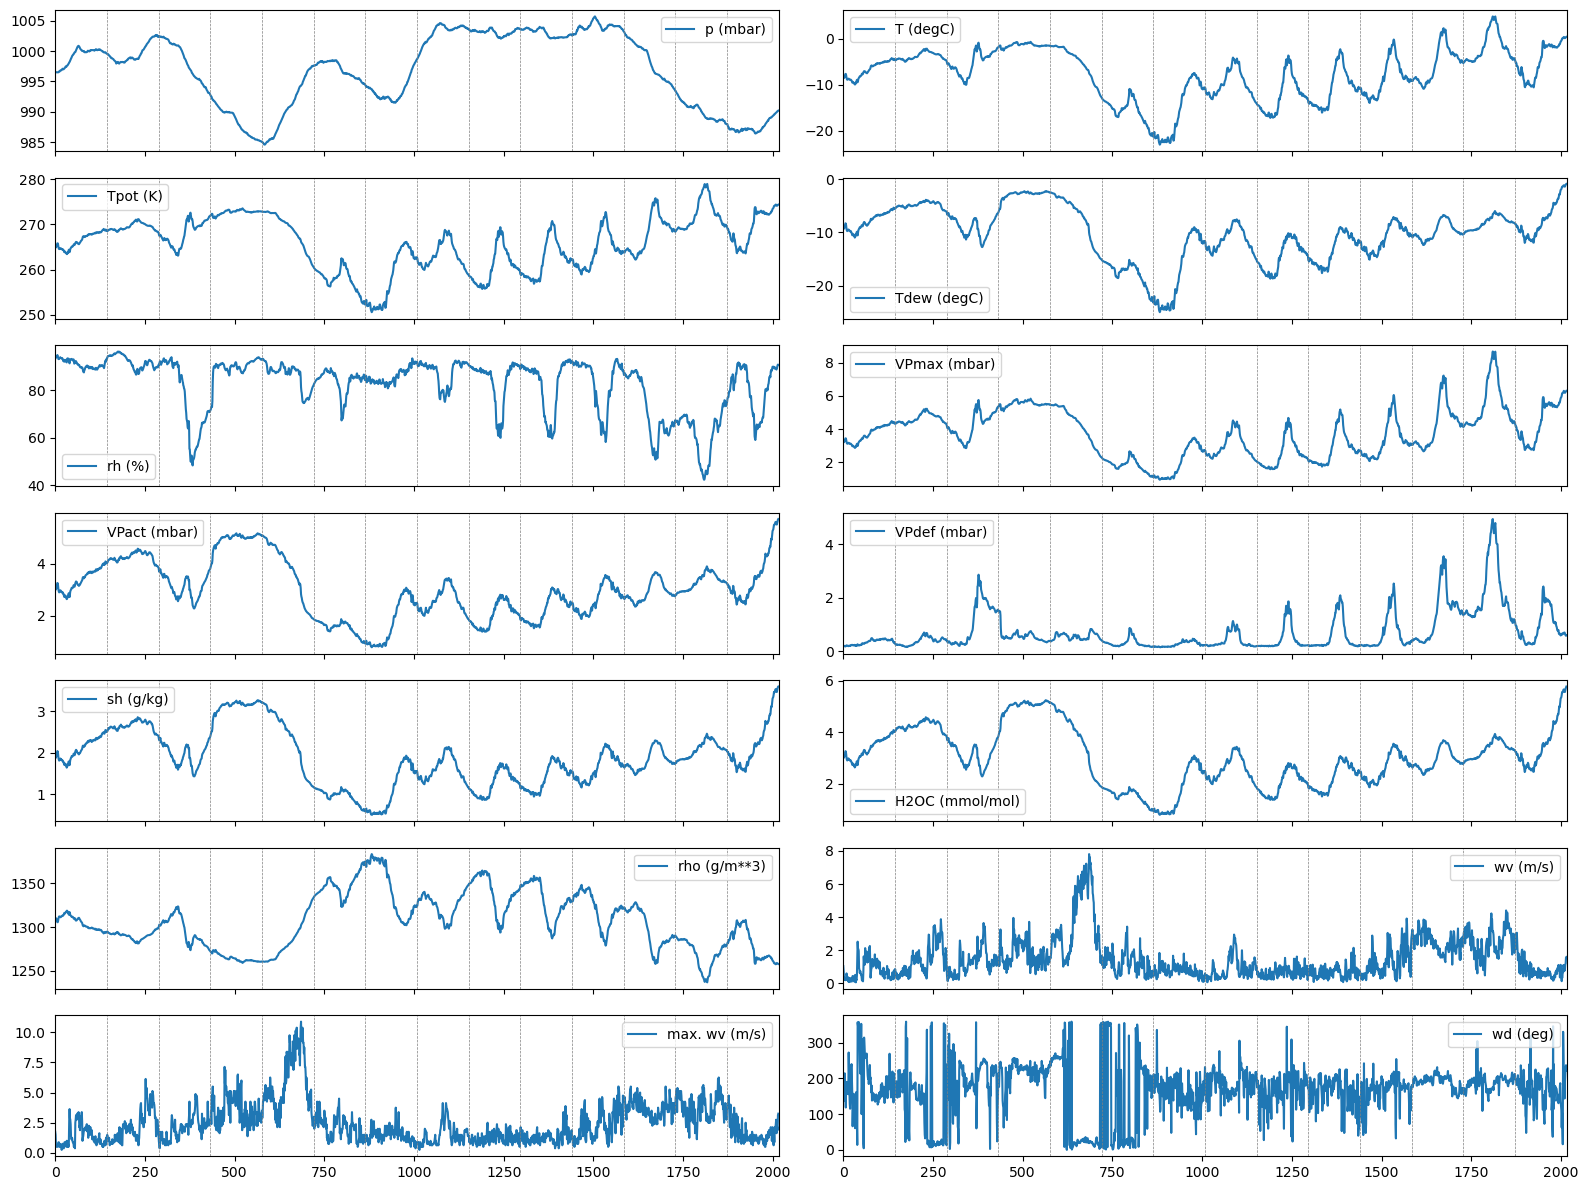

In [76]:
#from fnc_rnn import plot_data

daily_samples=144
n_days = 14

plot_data(data, samples_per_cycle=daily_samples, cycles=n_days)


## Preprocess Data

We start by removing the mean from the data and normalizing them by their standard deviation.

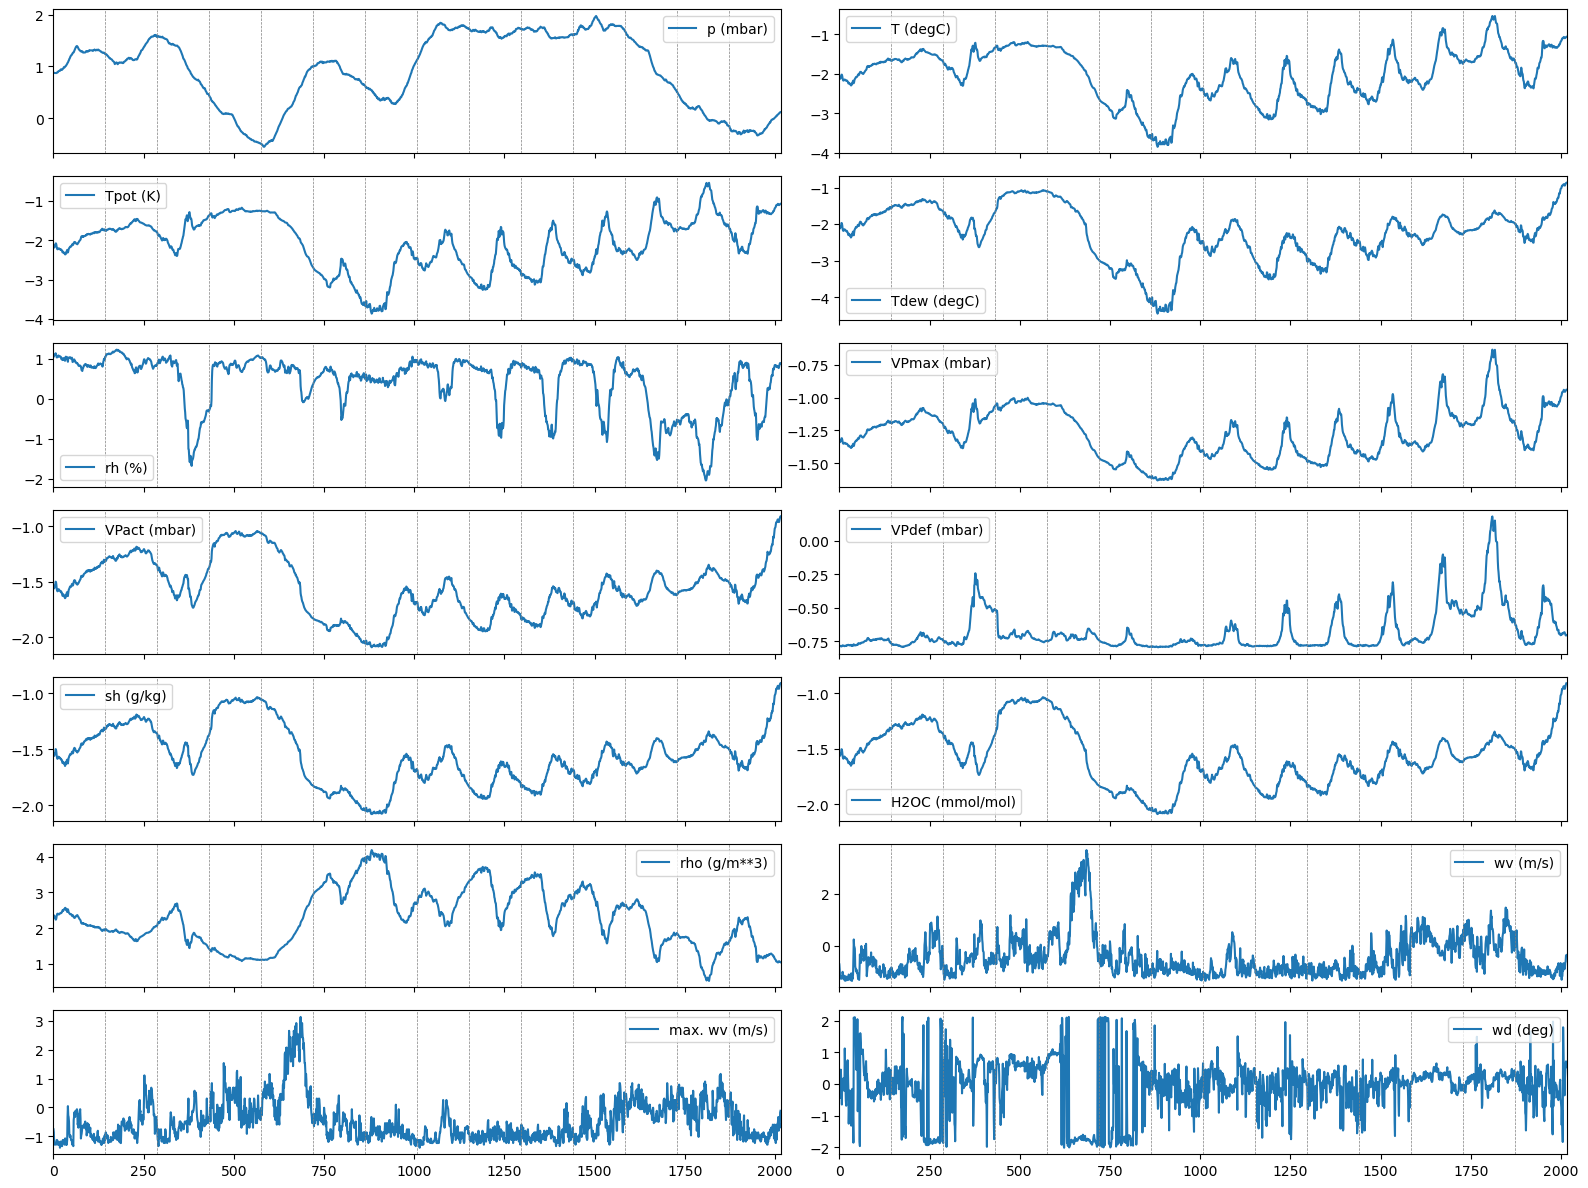

In [77]:
data -= data.mean(axis=0)
data /= data.std(axis=0)

plot_data(data, samples_per_cycle=daily_samples, cycles=n_days)

We now preprocess the data into time series to input into the neural network model, that is, they need to be of shape (batch size, number of samples, number of feature).

In [78]:
n_features = data.shape[-1]
samples = 256  # Length of the sequences to be fed to the RNN.
prediction_lag = 64  # How many time_steps ahead in time the RNN should predict temperature. 1 very easy. 18 used for course. 144 = 1 day

input = data[:-samples, :]
target = data[samples:, 2]  # Temperature.

dataLen = input.shape[0] - int(input.shape[0] % samples)
input = input[:dataLen]
target = target[:dataLen]

input = np.reshape(input, (-1, samples, n_features))
target = np.reshape(target, (-1, samples))
target = target[:, prediction_lag:prediction_lag + 1]

#shuffle input and target data
indices = np.arange(input.shape[0])
np.random.shuffle(indices)
input = input[indices]
target = target[indices]

print(data.shape)
print(input.shape)
print(target.shape)

(420451, 14)
(1641, 256, 14)
(1641, 1)


# RNN numpy model

This example implements the feed-forward pass of a recurrent neural network in numpy. To keep things simple, we assume that $x_t$ is a scalar value containing a single feature. 


<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/module-examples/models_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [ ]:
import numpy as np

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

time_series = [0, 1, 1, 2, 3, 5, 8]
state = 0

U = np.random.normal()
V = np.random.normal()
W = np.random.normal()
b = np.random.normal()

outputs = []

for t in time_series:
  hidden = sigmoid(np.dot(U,t) + np.dot(V,state)+b)
  output = sigmoid(np.dot(hidden, W))
  state=output
  outputs.append(output)

print(time_series)
print(outputs)

# PyTorch RNN model

This example introduces the module RNN in PyTorch.

In [ ]:
import torch
import torch.nn as nn

input_size = input_data.shape[-1] # Define based on your dataset
hidden_units = 2  # Example hidden units

# Define the RNN and Linear layers separately
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_units, batch_first=True)
fc = nn.Linear(hidden_units, 1)

# Loss and Optimizer
criterion = nn.L1Loss()  # MAE Loss
optimizer = torch.optim.Adam(list(rnn.parameters()) + list(fc.parameters()), lr=0.001)



In [ ]:
from torch.utils.data import random_split,TensorDataset, DataLoader

def create_data_loader(input_data, target_data, batch_size=32):

    # Convert to PyTorch tensors
    input_tensor = torch.tensor(input_data, dtype=torch.float32)
    target_tensor = torch.tensor(target_data, dtype=torch.float32)

    # Splitting the dataset into training and validation
    train_dataset = TensorDataset(input_tensor[:nr_of_sequences], target_tensor[:nr_of_sequences])
    train_dataset,val_dataset = random_split(train_dataset, [0.8, 0.2])
    # Creating data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

    return train_loader, val_loader

def create_benchmark(val_loader): #generate benchmark for comparison, i.e. predict T_t = T_{t-1}

    mae_benchmark=[]
    for inputs, targets in val_loader:
        val_predict_sequence = inputs[:, -1, 2]
        val_target_sequence = targets[:, 0]
        ae=torch.abs(val_predict_sequence - val_target_sequence)
        mae_benchmark.append(ae)

    mae_benchmark=torch.cat(mae_benchmark)
    mae_benchmark=torch.mean(mae_benchmark)
    return mae_benchmark

def train_model(rnn,fc, nr_of_sequences, epochs, criterion, optimizer,train_loader,val_loader):

    rnn.train()
    fc.train()
    train_losses = []
    val_losses = []

# Training Loop
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()

            # RNN layer
            rnn_out, _ = rnn(inputs)
            
            # Selecting the last output for each sequence
            rnn_out = rnn_out[:, -1, :]
            
            # Linear layer
            outputs = fc(rnn_out)
            
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation loop
        rnn.eval()
        fc.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                # RNN layer
                rnn_out, _ = rnn(inputs)
                
                # Selecting the last output for each sequence
                rnn_out = rnn_out[:, -1, :]
                
                # Linear layer
                outputs = fc(rnn_out)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print("Current Training Loss: {:.4f}".format(train_losses[-1])+ " Current Validation Loss: {:.4f}".format(val_losses[-1]))

    # Generate predictions on validation set
    with torch.no_grad():
        val_input_tensor = torch.tensor(input_data[nr_of_sequences:], dtype=torch.float32)
        val_rnn_out, _ = rnn(val_input_tensor)
        val_rnn_out = val_rnn_out[:, -1, :]
        val_predict_sequence = fc(val_rnn_out).numpy()
        val_target_sequence = target_data[nr_of_sequences:]
    return train_losses, val_losses,val_predict_sequence,val_target_sequence

import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses,mae_benchmark):
    plt.figure(figsize=(12, 12))
    plt.scatter(len(train_losses),mae_benchmark,marker='x',c='red', label=r"$T_t \approx T_{t-1}$")
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.legend(loc="best")
    plt.title("Loss over epochs")
    plt.grid(True)
    plt.show()

def train_and_plot(rnn,fc, nr_of_sequences, epochs,criterion, optimizer,train_loader,val_loader):
    train_losses, val_losses,val_predict_sequence,val_target_sequence = train_model(rnn,fc, nr_of_sequences,epochs,criterion,optimizer,train_loader, val_loader)
    plot_losses(train_losses, val_losses,mae_benchmark)
    return val_predict_sequence,val_target_sequence


nr_of_sequences=1600
epochs=50
train_loader, val_loader = create_data_loader(input_data, target_data)
mae_benchmark=create_benchmark(val_loader)
val_predict_sequence,val_target_sequence = train_and_plot(rnn,fc,nr_of_sequences,epochs,criterion,optimizer,train_loader, val_loader)

We implement the RNN in deeplay.

In [ ]:
rnn = dl.RNN(in_features=14,hidden_features=[hidden_units],out_features=1,rnn_type="RNN")
model = dl.Regressor(rnn,optimizer=dl.Adam(lr=0.001))
model=model.create()
print(model)

from lightning.pytorch.callbacks import Callback
class LossHistory(Callback):
    def on_train_start(self, trainer, pl_module):
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())
        val_loss = trainer.callback_metrics.get('val_loss')
        if train_loss is not None:
            self.val_losses.append(val_loss.item())

loss_history = LossHistory()
trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

Stacked RNN in Deeplay

In [ ]:

hidden_features=[32,32,32,32]
rnn = dl.RNN(in_features=14,hidden_features=hidden_features,out_features=1,rnn_type="RNN")
model = dl.Regressor(rnn,optimizer=dl.Adam(lr=0.001))
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)
plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)


Configure to stacked GRU instead

In [ ]:
rnn.blocks[:-1].layer.configure(torch.nn.GRU)
model = dl.Regressor(rnn)
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

Configure to stacked LSTM instead

In [ ]:
rnn.blocks[:-1].layer.configure(torch.nn.LSTM)
model = dl.Regressor(rnn)
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=epochs, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

Introduce dropout to prevent overfitting

In [ ]:

rnn.blocks.dropout.configure(p=0.2)
model = dl.Regressor(rnn)
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=50, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)

Introduce dense preprocessor in feature space

In [ ]:
hidden_size=32
hidden_features=[hidden_size]*4
dense_features=[hidden_size]*2

dense_preprocessor = dl.MultiLayerPerceptron(in_features=None,hidden_features=dense_features,out_features=hidden_features[0])
dense_preprocessor.dropout.configure(p=0.2)

rnn=dl.RNN(in_features=hidden_features[0],hidden_features=hidden_features,out_features=1,dropout=0.2,rnn_type="LSTM")

# Custom Reshape Layer
class Reshape(nn.Module):
    def __init__(self, new_shape):
        super(Reshape, self).__init__()
        self.new_shape = new_shape

    def forward(self, x):
        return x.view(self.new_shape)
    
dense_rnn = dl.Sequential(torch.nn.Flatten(start_dim=0,end_dim=1),dense_preprocessor,Reshape((-1, time_steps,hidden_features[-1])),rnn)
   
model = dl.Regressor(dense_rnn) 
model=model.create()
print(model)

trainer = dl.Trainer(max_epochs=50, callbacks=[loss_history],accelerator="auto")
trainer.fit(model, train_loader,val_dataloaders=val_loader)

plot_losses(loss_history.train_losses, loss_history.val_losses,mae_benchmark)